In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
cv2.destroyAllWindows()

# Image alteration
We would like to filter the test image in order to find the snooker table, by checking for green pixels in the image. In order to do so, we first perform some pre-processing to help with the filtering.

Firstly, we apply a median blur to the image. This replaces each pixel with the median of all surrounding pixels in the kernel area. This is done to reduce noise.

Then, we apply a scaling factor to all the colors in the image, essentially making it brighter. In practice, a linear transformation is applied to the intensity of each pixel in the image.

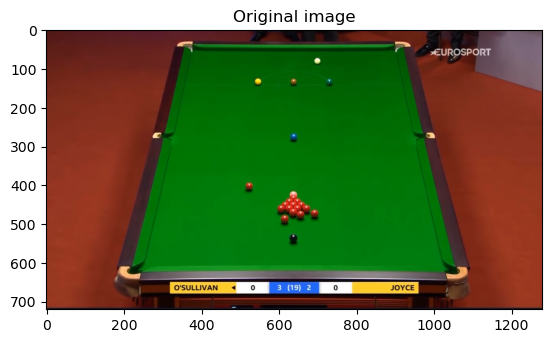

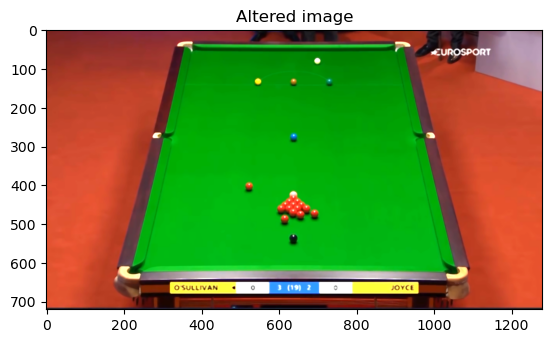

In [2]:
image_path = 'test_image.png'  

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.title('Original image')
plt.show()

# To apply median blur
def custom_median_blur(image, kernel_size):
    padded_image = np.pad(image, ((kernel_size//2, kernel_size//2), (kernel_size//2, kernel_size//2), (0, 0)), mode='reflect')
    result = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(image.shape[2]):
                result[i, j, k] = np.median(padded_image[i:i+kernel_size, j:j+kernel_size, k])
    return result

# To brighten the image
def custom_convert_scale_abs(image, alpha, beta):
    result = alpha * image + beta
    result = np.clip(result, 0, 255).astype(np.uint8)
    return result

image = custom_median_blur(image, 5)
image = custom_convert_scale_abs(image, 1.5, 0)

plt.imshow(image)
plt.title('Altered image')
plt.show()

# Black and white mapping
After applying these modifications, the image can be transformed into a binary, black-and-white image, mapping all very green pixels to white and all other pixels to black. More specifically, all pixels which have a notably higher intensity of green compared to both red and blue are mapped to white, and only those pixels. The specific relative strength of the required intensity is determined by a threshold parameter.

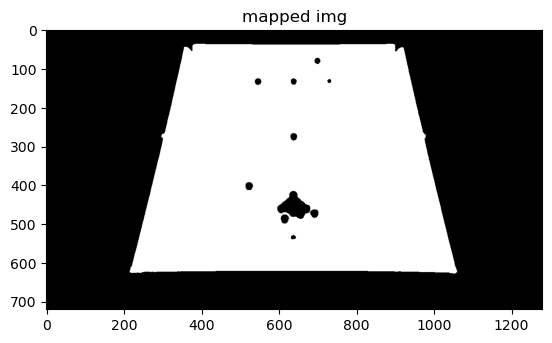

In [3]:
def map_to_gray(image, threshold=1.5):
    mask = (image[:, :, 1] > image[:, :, 0]*threshold) & (image[:, :, 1] > image[:, :, 2]*threshold)
    gray_mapped = np.where(mask, 255, 0)

    return gray_mapped.astype(np.uint8)


image = map_to_gray(image)
plt.imshow(image, cmap='gray')
plt.title('mapped img')
plt.show()

# Edge detection
After finding the pixels corresponding to the snooker table, we can use edge detection to find the table borders. We use Canny edge detection, meaning our work is split in different phases:
1. Sobel filters: Following the theory, we define two operators that respond to horizontal and vertical edges respectively, by approximating a derivative in one direction and Gaussian smoothing in the other. We use them to define a combined filter, the gradient magnitude, by taking the square root of the sum of their quares.
2. Non-maxima suppression: We suppress non-maximum pixels to find thinner edges. By checking the neighboring gradient magnitude of each pixel in the image, we classify the edge at that pixel as horizontal, vertical, right-diagonal or left-diagonal. We choose the two neighboring points of each pixel depending on the classification and we filter out any points whose gradient magnitude is lowe than its neighbors'.
3. Double thresholding: We set two thresholding values. Pixels with a lower intensity than both values are classified as not edge-pixels, pixels with a higher intensity than both values are classified as strong edge-pixels, and the remaining pixels are classified as weak edge-pixels.
4. Hysteresis: Using a hysteresis operation, all weak pixels neighboring strong pixels are "promoted" to strong pixels, whereas all the others are set to 0.

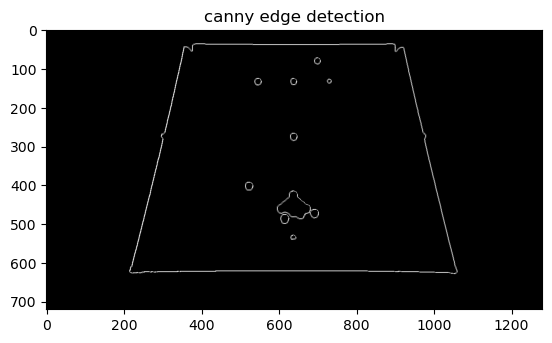

In [4]:
from scipy.ndimage import convolve

# Sobel filters
def sobel_filters(img):
    # Filters: Sobel operator
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    # Convolution
    Ix = convolve(img, Kx)
    Iy = convolve(img, Ky)
    
    # Gradient magnitude
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return G, theta

# Non-maxima suppression
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M, N), dtype=np.int32) 
    angle = D * 180. / np.pi  
    angle[angle < 0] += 180  

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                neighbors = [img[i, j-1], img[i, j+1]]
            elif (22.5 <= angle[i, j] < 67.5):
                neighbors = [img[i-1, j+1], img[i+1, j-1]]
            elif (67.5 <= angle[i, j] < 112.5):
                neighbors = [img[i-1, j], img[i+1, j]]
            elif (112.5 <= angle[i, j] < 157.5):
                neighbors = [img[i-1, j-1], img[i+1, j+1]]

            if img[i, j] >= max(neighbors):
                Z[i, j] = img[i, j]
    return Z

# Double thresholding
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = img.shape
    res = np.zeros((M, N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    weak_i, weak_j = np.where((img >= lowThreshold) & (img < highThreshold))
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return res, weak, strong

# Hysteresis
def hysteresis(img, weak, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if img[i,j] == weak:
                # check all 8 neighbors 
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or 
                    (img[i+1, j+1] == strong) or (img[i, j-1] == strong) or 
                    (img[i, j+1] == strong) or (img[i-1, j-1] == strong) or 
                    (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img

def canny_edge_detection(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    G, theta = sobel_filters(img)
    Z = non_max_suppression(G, theta)
    res, weak, strong = threshold(Z, lowThresholdRatio, highThresholdRatio)
    edges = hysteresis(res, weak, strong)
    return edges

edges = canny_edge_detection(image)
plt.imshow(edges, cmap='gray')
plt.title('canny edge detection')
plt.show()

# Line detection
The edges just found can be used for line detection, by making use of the Hough transform. Following the theory, for every non-zero pixel $(x,y)$ and for every angle $\theta$, the value $\rho = xcos(\theta) + ysin(\theta)$ is calculated, corresponding to the line $(\rho, \theta)$; then a "vote" for that line is added to an accumulator. Many "votes" being added for a specific line means that many non-zero pixels lie on that line in the image: therefore, we can find the lines in the image by only taking the lines whose "votes" in the accumulator are above a certain high threshold.

In the case of this problem, we also perform an additional step by adjusting all the sightly horizontal lines to be perfectly horizontal: first we filter out the slightly horizontal lines by their angle, then we adjust said angle to be 0. In our case, it's a small correction.

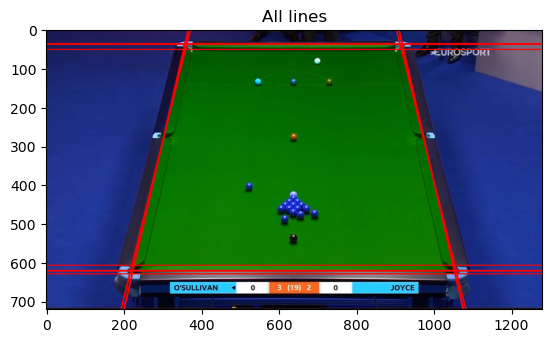

In [5]:
rho_resolution = 1
theta_resolution = np.pi / 180
min_theta = 0
max_theta = np.pi
threshold = 200 

# Calculate the Hough space and detect the lines
def hough_lines(edges, threshold, min_theta, max_theta, rho_resolution, theta_resolution):
    height, width = edges.shape
    diagonal = np.sqrt(height**2 + width**2)

    theta_angles = np.arange(min_theta, max_theta, theta_resolution)
    rho_values = np.linspace(-diagonal, diagonal, int(2 * diagonal / rho_resolution) + 1)

    num_thetas = len(theta_angles)
    num_rhos = len(rho_values)
    accumulator = np.zeros((num_rhos, num_thetas))

    sins = np.sin(theta_angles)
    coss = np.cos(theta_angles)

    y_idxs, x_idxs = np.where(edges > 0)

    for x, y in zip(x_idxs, y_idxs):
        for idx in range(num_thetas):

            rho = x * coss[idx] + y * sins[idx]
            rho_index = np.argmin(np.abs(rho_values - rho))
            accumulator[rho_index, idx] += 1

    idx_rhos, idx_thetas = np.where(accumulator > threshold)
    final_rhos = rho_values[idx_rhos]
    final_thetas = theta_angles[idx_thetas]

    polar_coordinates = np.column_stack((final_rhos, final_thetas))
    return polar_coordinates

# Filter the vertical and horizontal lines
def filter_vertical_lines(lines, angle_threshold_deg):
    vertical_lines = []
    horizonal_lines = []
    angle_threshold_rad = np.radians(angle_threshold_deg)
    min_theta = np.pi/2 - angle_threshold_rad
    max_theta = np.pi/2 + angle_threshold_rad
    vertical_lines = [line for line in lines if min_theta <= line[1] <= max_theta]
    horizonal_lines = [line for line in lines if min_theta > line[1] or line[1] > max_theta]
    return np.array(vertical_lines), np.array(horizonal_lines)

# Adjust the lines to be horizontal
def adjust_lines_to_horizontal(lines):
    adjusted_lines = []
    for rho, theta in lines:
        x0 = rho * np.cos(theta)
        y0 = rho * np.sin(theta)
        new_rho = y0 
        adjusted_lines.append((new_rho, np.pi / 2))
        
    return np.array(adjusted_lines)

lines = hough_lines(edges, threshold, min_theta, max_theta, rho_resolution, theta_resolution)
horizontal_lines, vertical_lines = filter_vertical_lines(lines, 20)
horizontal_lines = adjust_lines_to_horizontal(horizontal_lines)

# PLot the lines
def plot_lines(image, lines, size_line=3000):
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + size_line * (-b))
        y1 = int(y0 + size_line * (a))
        x2 = int(x0 - size_line * (-b))
        y2 = int(y0 - size_line * (a))
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

image_real = cv2.imread(image_path)
plot_lines(image_real, horizontal_lines)
plot_lines(image_real, vertical_lines)
plt.imshow(image_real)
plt.title('All lines')
plt.show()

# Line filtering
Rather than just one line, the Hough transform finds many similar lines in close positions. To get around this, we filter only four of those, corresponding to the four edges of the snooker table. We do so by selecting the two horizontal lines with maximum and minimum $y$ coordinate, as well as the two non-horizontal lines with maximum and minimum $x$ coordinate (with some adjustments).

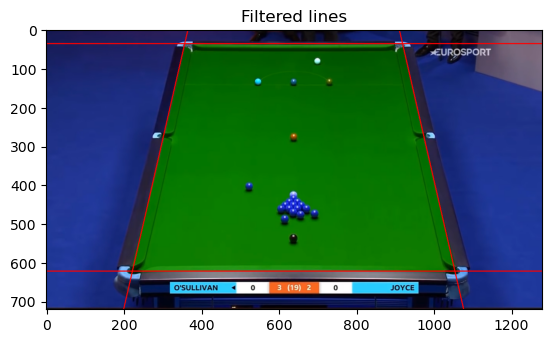

In [6]:
# get the horizontal line that have  min y at x = 0
# get the horizontal line that have  max y at x = 0
# for the line with max y we get the second max y
def get_min_max_y_horizontal_lines(lines):
    # Lines have the form (rho, theta) so we can sort based on y using the rho * np.sin(theta)
    sorted_line_y = sorted(lines, key=lambda x: x[0] * np.sin(x[1]))
    min_y_line = sorted_line_y[0]
    max_y_line = sorted_line_y[len(sorted_line_y) - 2]
    return min_y_line, max_y_line

min_y_line, max_y_line = get_min_max_y_horizontal_lines(horizontal_lines)
horizontal_lines = np.array([min_y_line, max_y_line])

# lover the y value of min_y_line from 2 pixels
#min_y_line = (min_y_line[0], min_y_line[1] + np.pi/2)

# get the vertical line that have  min x at y = 0
# get the vertical line that have  max x at y = 0
def get_min_max_x_vertical_lines(lines):
    min_x = np.inf
    max_x = -np.inf
    min_x_line = None
    max_x_line = None
    for rho, theta in lines:
        x0 = rho * np.cos(theta)
        y0 = rho * np.sin(theta)
        if x0 < min_x:
            min_x = x0
            min_x_line = (rho, theta)
        if x0 > max_x:
            max_x = x0
            max_x_line = (rho, theta)
    return min_x_line, max_x_line

min_x_line, max_x_line = get_min_max_x_vertical_lines(vertical_lines)
vertical_lines = np.array([min_x_line, max_x_line])

# merge line arrays
lines = np.concatenate((horizontal_lines, vertical_lines), axis=0)

# plot
image_real = cv2.imread(image_path)

plot_lines(image_real, lines)
plt.imshow(image_real)
plt.title('Filtered lines')
plt.show()

# Calculation of intersection points

A connection between the points of a line in polar coordinates and Cartesian coordinates is given by the Hesse normal form:

\begin{equation}
\rho = x \cos(\theta) + y \sin(\theta)
\end{equation}

Let us consider two lines $(\rho_1,\theta_1)$ and $(\rho_2,\theta_2)$. The intersection point $(x,y)$ for the two lines must obviously lie on both lines, so it must satisfy the following linear system:

\begin{equation}
\begin{cases}
x \cos(\theta_1) + y \sin(\theta_1) = \rho_1 \\
x \cos(\theta_2) + y \sin(\theta_2) = \rho_2
\end{cases}
\end{equation}

This can be rewritten in matrix form as $ A \mathbf{x} = \mathbf{b} $, with

$
A = \begin{bmatrix}
\cos(\theta_1) & \sin(\theta_1) \\
\cos(\theta_2) & \sin(\theta_2)
\end{bmatrix}, \quad
\mathbf{x} = \begin{bmatrix}
x \\
y
\end{bmatrix}, \quad
\mathbf{b} = \begin{bmatrix}
\rho_1 \\
\rho_2
\end{bmatrix}
$

Thererfore, the intersection of the two lines is determined by solving the linear system, finding
$
\mathbf{x} = A^{-1} \mathbf{b}
$.

Our code finds the four intersection points between the four lines found earlier, representing the corner points of the table. The function $\texttt{np.linalg.solve}$ is used for the purpose. Afterwards, the points are sorted so they can be managed more easily.

Intersection Point 1: (222.18, 622.54)
Intersection Point 2: (357.25, 37.50)
Intersection Point 3: (920.59, 37.50)
Intersection Point 4: (1055.66, 622.54)


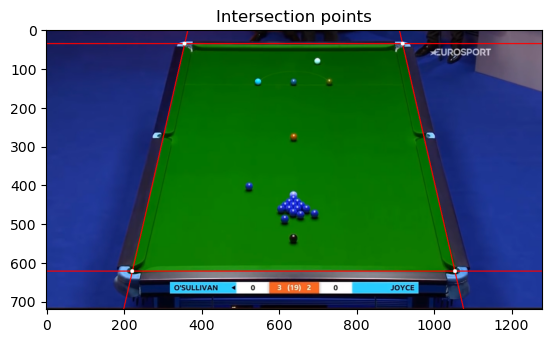

In [7]:
# Compute intersection points
intersection_points = []
for rho1, theta1 in horizontal_lines:
    for rho2, theta2 in vertical_lines:
        A = np.array([[np.cos(theta1), np.sin(theta1)], [np.cos(theta2), np.sin(theta2)]])
        b = np.array([rho1, rho2])
        intersection_point = np.linalg.solve(A, b)
        intersection_points.append(intersection_point)

# Sort point to manage more easily
intersection_points.sort(key=lambda x: x[0])
intersection_points_pos = []

# Visualization: plot lines and points
image_path = 'test_image.PNG'  
output_image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plot_lines(output_image, lines)

i = 0
for intersection_point in intersection_points:
    x, y = intersection_point
    print(f'Intersection Point {i + 1}: ({x:.2f}, {y:.2f})')
    intersection_points_pos.append((x, y))
    cv2.circle(output_image, (int(x), int(y)), 5, (255, 255, 255), -1)
    i += 1

plt.imshow(output_image)
plt.title('Intersection points')
plt.show()

# Prespective matrix
The function $\texttt{find_prespective_transform}$ is designed to compute the perspective transformation matrix that maps a set of four source points $\texttt{pts1}$ to a set of four destination points ($\texttt{pts2}$). The process involves setting up and solving a system of linear equations derived from these point correspondences, by utilizing a variant of the DLT algorithm.

More specifically, the matrix equation can be expressed as:
$ A \mathbf{x} = \mathbf{0} $
where $A$ is an $8 \times 9$ matrix constructed as follows for each point pair $(x, y)$ from $\texttt{pts1}$ and $(u, v)$ from $\texttt{pts2}$:

$\begin{array}{l}
\text{For each point pair, two rows are added to } A: \\
\text{Row } 2i: [x, y, 1, 0, 0, 0, -ux, -uy, -u] \\
\text{Row } 2i+1: [0, 0, 0, x, y, 1, -vx, -vy, -v]
\end{array}$

The solution $\mathbf{x}$ represents the flattened perspective transformation matrix. It can be found by computing the Singular Value Decomposition (SVD) of $A$ and taking the last row of the matrix $V$ (from the decomposition $U, S, V = \text{svd}(A)$): this is because this solution either is exact, or minimizes the algebraic error of the system. $\mathbf{x}$ is then reshaped into a $3 \times 3$ matrix: this matrix $M$ is the desired perspective transformation matrix.

$M$ can then be used to perform perspective warping of images, aligning the source points to the destination points through geometric transformations.

In the case of this problem, the set $\texttt{pts2}$ is made up of the intersection points found earlier. The set $\texttt{pts1}$, on the other hand, is set manually using known data about the dimensions of the snooker table and correcting for the length of the cushions. The code is split in two parts: the first is a showcase of the transformation, meaning that it's only there for visualization purposes, so it scales the image by a factor of 1000 first. The second is the actual calculation of the matrix.

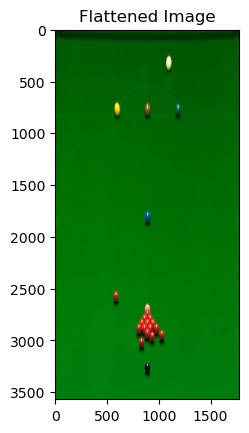

In [8]:
cushions_len = 0.08

def find_prespective_transform(pts1, pts2):
    A = np.zeros((8, 9))
    for i in range(4):
        x, y = pts1[i]
        u, v = pts2[i]
        A[i * 2] = [x, y, 1, 0, 0, 0, -u * x, -u * y, -u]
        A[i * 2 + 1] = [0, 0, 0, x, y, 1, -v * x, -v * y, -v]
    U, S, V = np.linalg.svd(A)
    M = V[-1].reshape(3, 3)
    return M

# Visual showcase of the transformation

cv2.destroyAllWindows()
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


A = (0,3.569)
B = (0, 0)
C = (1.778,0)
D = (1.778, 3.569)

A = (A[0] - cushions_len, A[1] + cushions_len)
B = (B[0] - cushions_len, B[1] - cushions_len)
C = (C[0] + cushions_len, C[1] - cushions_len)
D = (D[0] + cushions_len, D[1] + cushions_len)

A = (A[0] * 1000, A[1] * 1000)
B = (B[0] * 1000, B[1] * 1000)
C = (C[0] * 1000, C[1] * 1000)
D = (D[0] * 1000, D[1] * 1000)

pts1 = np.float32([A,B,C,D])
pts2 = np.float32(intersection_points_pos)


from PIL import Image

def manual_warp_perspective(image_in, M, out_h, out_w):
    image = image_in.copy()

    output_image = np.zeros((out_h, out_w, 3), dtype=np.uint8)
    
    M_inv = np.linalg.inv(M)
    height, width, _ = image.shape

    for y in range(out_h):
        for x in range(out_w):

            # STEP 1 get homogeneous coordinates
            output_coords = np.array([x, y, 1])

            # STEP 2 apply inverse transformation + normalization
            input_coords = M_inv.dot(output_coords)
            input_coords /= input_coords[2] 

            # STEP 3 add into the final image
            x_in, y_in = int(input_coords[0]), int(input_coords[1])
            output_image[y, x] = image[y_in, x_in]

    return output_image


M_visiva = find_prespective_transform(pts2, pts1)


cv2.destroyAllWindows()
image = cv2.imread(image_path)
image_real = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

out_img = manual_warp_perspective(image_real, M_visiva, 3569, 1778)
plt.imshow(out_img)
plt.title('Flattened Image')
plt.show()

# Actual computation of the transformation matrix

A = (0,3.569)
B = (0, 0)
C = (1.778,0)
D = (1.778, 3.569)

A = (A[0] - cushions_len, A[1] + cushions_len)
B = (B[0] - cushions_len, B[1] - cushions_len)
C = (C[0] + cushions_len, C[1] - cushions_len)
D = (D[0] + cushions_len, D[1] + cushions_len)

pts1 = np.float32([A,B,C,D])
pts2 = np.float32(intersection_points_pos)

M = find_prespective_transform(pts2, pts1)
M_inv = np.linalg.inv(M)

# Visualization: ball positions through the perspective matrix
Some of the balls in the test frame are in their initial positions, so we can use known facts about their position to calculate their pixel coordinates through the perspective matrix.

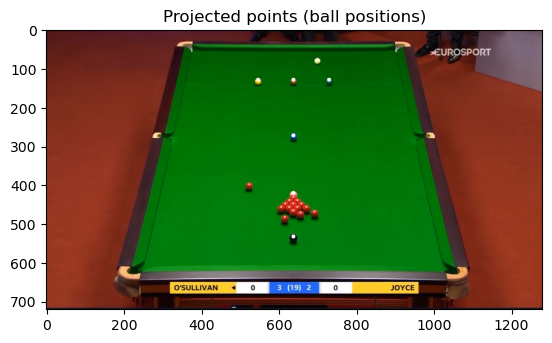

In [9]:
# table center
middle_y = 3.569/2
middle_x = 1.778/2

# (yellow, green, brown, blue, pink, black balls)
points = np.array([
    [middle_x - 0.292, middle_y - 1.0475],  # yellow
    [middle_x + 0.292, middle_y - 1.0475],  # green
    [middle_x, middle_y - 1.0475],          # brown
    [middle_x, middle_y],                   # blue
    [middle_x, middle_y + 0.89225],         # pink
    [middle_x, middle_y + 1.4605]           # black
])


# Apply transformation
def apply_transformation_to_points(points, M):
    transformed_points = []
    for point in points:
        #print(point)
        point_homog = np.array([point[0], point[1], 1])
        transformed_point = np.dot(np.linalg.inv(M), point_homog) 
        transformed_point /= transformed_point[2] 
        transformed_points.append(transformed_point[:2])
    return np.array(transformed_points)

projected_points = apply_transformation_to_points(points, M)

# Read image
cv2.destroyAllWindows()
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Draw points
output_image = image_rgb.copy()
for point in projected_points:
    cv2.circle(output_image, (int(point[0]), int(point[1])), 5, (255, 255, 255), -1)

# Plot image
plt.imshow(output_image)
plt.title('Projected points (ball positions)')
plt.show()

# Calculate table area
Similarly, we can use the projected points from the corners of the table to calculate the table area (as a trapezoid) as well as color the surface of the table.

Area of the table is 356454.69327086373 m^2


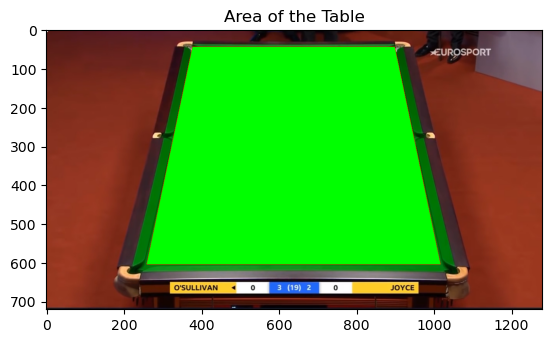

In [10]:
# Calculate the table area
A_2 = (0,3.569)
B_2 = (0,0)
C_2 = (1.778,0)
D_2 = (1.778, 3.569)

new_angle_pts = np.float32([A_2,B_2,C_2,D_2])
new_angle_pts = apply_transformation_to_points(new_angle_pts, M)

A_2_new = new_angle_pts[0]
B_2_new = new_angle_pts[1]
C_2_new = new_angle_pts[2]
D_2_new = new_angle_pts[3]

larger_base = D_2_new[0] - A_2_new[0] 
small_base = C_2_new[0] - B_2_new[0]
height = A_2_new[1] - B_2_new[1]

Area = (larger_base+small_base) * height/2

print(f'Area of the table is {Area} m^2')

# Plot the area in green
output_image = image_rgb.copy()
for i in range(4):
    cv2.line(output_image, (int(new_angle_pts[i][0]), int(new_angle_pts[i][1])), (int(new_angle_pts[(i + 1) % 4][0]), int(new_angle_pts[(i + 1) % 4][1])), (255, 0, 0), 2)
    cv2.fillPoly(output_image, np.array([new_angle_pts], dtype=np.int32), (0, 255, 0, 100))

cv2.circle(output_image, (int(A[0]), int(A[1])), 5, (255, 255, 255), -1)
plt.imshow(output_image)
plt.title('Area of the Table')
plt.show()

# Calculate camera position
To find the camera position, we can employ the DLT algorithm, through the use of 3D world coordinates and 2D pixel coordinates for a set of (at least) six points. This process was carried out in these steps:

1. Get 2D world coordinates and pixel coordinates of the points. The points themselves were chosen as the four borders of the snooker table, plus two of the balls. The 2D world coordinates were taken using given information about the snooker table, whereas the pixel coordinates were taken by projecting the world coordinates onto the image through the perspective matrix and then manually adjusting the results.
2. Add the $z$ axis to the world coordinates. This was done manually, taking into account which points are on the playing table and which points are at the top of the balls.
3. Compute the camera matrix. This is where the DLT algorithm is used. In a similar fashion to how the perspective matrix was computed, a matrix A was built using the points $(X,Y,Z)$ in world coordinates together with their corresponding pixel coordinates $(u,v)$:

$\begin{array}{l}
\text{For each point pair, two rows are added to } A: \\
\text{Row } 2i: [-X, -Y, -Z, -1, 0, 0, 0, 0, uX, uY, uZ, u] \\
\text{Row } 2i+1: [0, 0, 0, 0, -X, -Y, -Z, -1, vX, vY, vZ, v]
\end{array}$

Then, the solution is found through SVD as with the perspective matrix and it's reshaped in a 3 $\times$ 4 matrix.

4. Decompose the camera matrix. The camera matrix can be factorized using QR factorization, which allows for the extraction of the camera calibration matrix $K$ and the camera orientation $R$.
5. Compute the camera position $C$ using $K$ and $R$, following the theory.

The code also includes plot visualizations of the points and the camera.

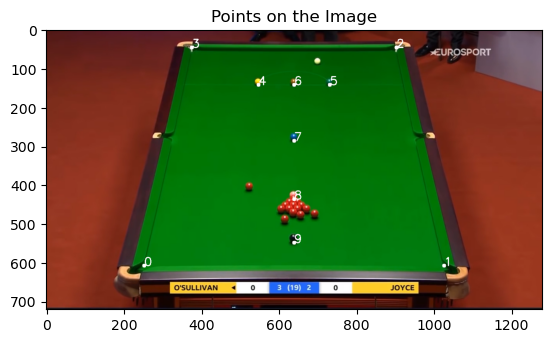

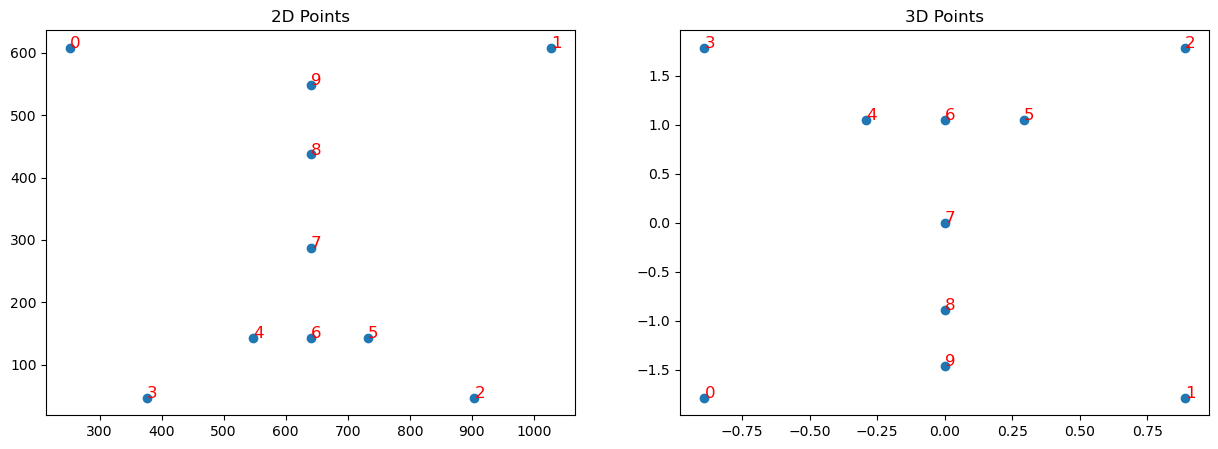

ERROR: [253.09265142 608.09969503] != [253 608]
Equal KR = M_3x3: False
Camera Position: [ 4.90218213e-04 -5.91468648e+00  2.22740298e+00]
Equal C in nullspace: True


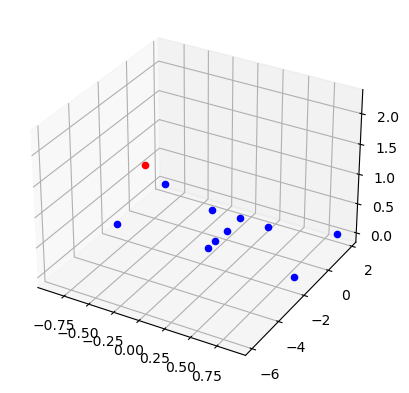

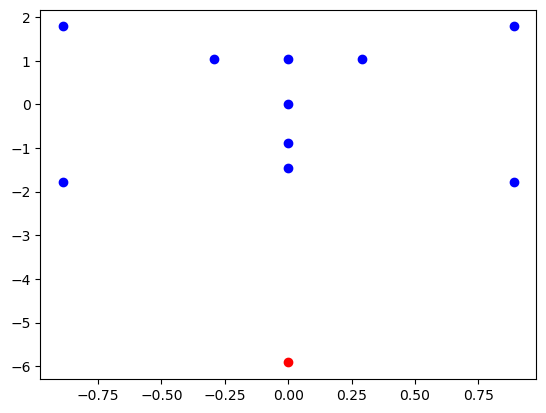

In [130]:
DEBUG = True

# Get 2D world coordinates and pixel coordinates
A_2 = (0,0)
B_2 = (middle_x, middle_y)
C_2 = (middle_x, middle_y + 1.4605)
D_2 = (1.778,0)
A = (0,3.569)
B = (1.778,3.569 )

world_coords = np.array([
    A_2,
    B_2,
    C_2,
    D_2,
    A,
    B,
])

pixel_coords = apply_transformation_to_points(world_coords, M)

# Adjust pixel coordinates
pixel_coords[3][1] = pixel_coords[3][1] + 5
pixel_coords[0][1] = pixel_coords[0][1] + 5
pixel_coords[2][1] = pixel_coords[2][1] - 2
pixel_coords[1][1] = pixel_coords[1][1] - 2

plt.imshow(output_image)
plt.title('Points on the Image')
plt.show()

# Make the world coordinates 3D, so add Z 0.8 for the table and 0.8 + 0.02625
TABLE_HEIGHT = 0.0
BALL_RADIUS = 0.02625

world_coords_3d = np.array([
    [A_2[0], A_2[1], TABLE_HEIGHT],
    [B_2[0], B_2[1], TABLE_HEIGHT + BALL_RADIUS*2],  
    [C_2[0], C_2[1], TABLE_HEIGHT + BALL_RADIUS*2],
    [D_2[0], D_2[1], TABLE_HEIGHT],
    [A[0], A[1], TABLE_HEIGHT],
    [B[0], B[1], TABLE_HEIGHT],
])

# Set origin at the center of the table x and y for 2D and 3D and flip the y axis
world_coords_3d[:, 0] = world_coords_3d[:, 0] - 1.778/2
world_coords_3d[:, 1] = world_coords_3d[:, 1] - 3.569/2
pixel_coords[:, 0] = pixel_coords[:, 0]- image.shape[1]/2 
pixel_coords[:, 1] = pixel_coords[:, 1]- image.shape[0]/2 

pixel_coords[:, 1] = -pixel_coords[:, 1]
world_coords_3d[:, 1] = -world_coords_3d[:, 1]

####################
#######NICKY########
####################
world_coords_3d = np.array([[-0.889, -1.7845, 0.03], [0.889, -1.7845, 0.03], [0.889,  1.7845, 0.03], [-0.889,  1.7845, 0.03], [-0.292, 1.0475, 0], [0.292, 1.0475, 0],
    [0, 1.0475, 0], [0, 0, 0], [0,-0.89225, 0], [0,-1.4605, 0]])
pixel_coords =  np.array([[253, 608], [1027, 608], [904,  47], [376,  47], [548, 143], [732, 143], [640, 143], [640, 287], [640, 437], [640, 549]])
###################
###################

# Plot the points on the image
output_image = image_rgb.copy()
for i, point in enumerate(pixel_coords):
    cv2.circle(output_image, (int(point[0]), int(point[1])), 5, (255, 255, 255), -1)
    cv2.putText(output_image, str(i), (int(point[0]), int(point[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# Plot the pixel and world coordinates of the points
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].scatter(pixel_coords[:, 0], pixel_coords[:, 1])
axs[0].set_title('2D Points')
for i, point in enumerate(pixel_coords):
    axs[0].text(point[0], point[1], str(i), fontsize=12, color='red')
axs[1].scatter(world_coords_3d[:, 0], world_coords_3d[:, 1])
axs[1].set_title('3D Points')
for i, point in enumerate(world_coords_3d):
    axs[1].text(point[0], point[1], str(i), fontsize=12, color='red')
plt.show()

# Compute the camera matrix using DLT
def compute_camera_matrix(world_coords, pixel_coords):
    # compute A matrix
    A = np.zeros((2 * len(world_coords), 12))
    for i in range(len(world_coords)):
        X, Y, Z = world_coords[i]
        u, v = pixel_coords[i]
        A[2 * i] = [-X, -Y, -Z, -1, 0, 0, 0, 0, u * X, u * Y, u * Z, u]
        A[2 * i + 1] = [0, 0, 0, 0, -X, -Y, -Z, -1, v * X, v * Y, v * Z, v]
    # compute SVD
    U, S, V = np.linalg.svd(A)
    return V[-1].reshape(3, 4)
M_camera = compute_camera_matrix(world_coords_3d, pixel_coords)

if DEBUG:
    flag = True
    for i in range(len(world_coords_3d)):
        point_3d = np.array([world_coords_3d[i][0], world_coords_3d[i][1], world_coords_3d[i][2], 1])
        point_2d = M_camera.dot(point_3d)
        point_2d /= point_2d[2]
        # if not eqal brake and print ERROR
        if not np.allclose(point_2d[:2], pixel_coords[i]):
            print(f'ERROR: {point_2d[:2]} != {pixel_coords[i]}')
            flag = False
            break
    if flag:
        print('All points are equal')

# Decompose the camera matrix to get the intrinsic and extrinsic parameters
def decompose_camera_matrix(M):
    M3x3 = M[:, :3]
    Q, R = np.linalg.qr(np.linalg.inv(M3x3))
    
    # Correcting signs for positive diagonal in K
    T = np.diag(np.sign(np.diag(R)))
    K = np.dot(R, T)
    R = np.dot(np.linalg.inv(T), Q)
    
    return K, R.T
K, R = decompose_camera_matrix(M_camera)

if DEBUG:
    # check if K and R give our P matrix
    M_3x3 = M_camera[:, :3]
    KR = K.dot(R)
    print(f'Equal KR = M_3x3: {np.allclose(KR, M_3x3)}')
    
# Compute camera position
def compute_camera_position(M):
    M_3x3 = M[:, :3]
    M_4 = M[:, 3]
    C = -np.linalg.inv(M_3x3).dot(M_4)
    return C
C = compute_camera_position(M_camera)

print(f'Camera Position: {C}')

if DEBUG:
    # check if C is in the nullspace of the P
    print(f'Equal C in nullspace: {np.allclose(M_camera.dot(np.array([C[0], C[1], C[2], 1])), 0)}')

# Plot camera position and world coordinates in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(C[0], C[1], C[2], c='r', marker='o')
for i in range(len(world_coords_3d)):
    ax.scatter(world_coords_3d[i][0], world_coords_3d[i][1], world_coords_3d[i][2], c='b', marker='o')
plt.show()

# Show only x and y in 2D
fig, ax = plt.subplots()
ax.scatter(C[0], C[1], c='r', marker='o')
for i in range(len(world_coords_3d)):
    ax.scatter(world_coords_3d[i][0], world_coords_3d[i][1], c='b', marker='o')
plt.show()

# Filter for white pixels
We're now interested in finding the ball positions on the image. In order to do so, a black and white mapping is performed on the image based on the grayscale intensity of each pixel (i.e. the average of color intensities at each pixel). Then, by using the points found in the area calculation, all pixels outside the table area are set to 0. This leaves one stray white pixel in the top left corner of the table, which is set to 0 manually. After that, all clusters of white pixels correspond to a ball or to the white highlight on top of one.

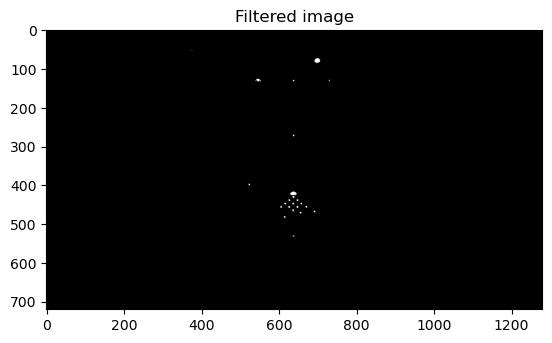

In [122]:
image_grayscale = np.average(image, axis=2)
image_grayscale = np.where(image_grayscale > 170, 255, 0)
temp = np.zeros(image_grayscale.shape)
cv2.fillPoly(temp, np.array([new_angle_pts], dtype=np.int32), 1)
image_grayscale = np.where(temp > 0, image_grayscale, 0)
image_grayscale[56,376] = 0
plt.imshow(image_grayscale, cmap='gray')
plt.title('Filtered image')
plt.show()

# Find ball positions
The specific ball positions are found through a custom connected components detection algorithm. By summing all the white pixels on the horizontal and vertical axes, we find ranges of horizontal and vertical coordinates in which the white pixels are located, creating rectangles of pixels on the binary image. These rectangles are actually too wide to be useful, since there may be overlap when summing over the axes. To get around this, the non-empty rectangles is then used as a mask on the image and the aforementioned process is repeated on the masked image for each rectangle. The non-empty rectangles found in this second iteration correspond to the connected components we're looking for, so the center of each rectangle is taken as the ball position on the image.

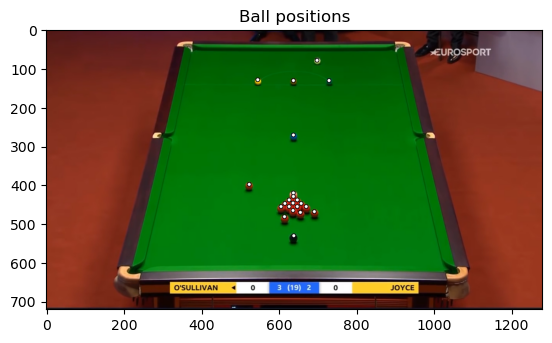

In [123]:
def find_ranges(data):
    ranges = []
    m = len(data)
    start = data[0]
    curr = start
    for i in range(m-1):
        if data[i] == curr:
            curr += 1
        else:
            ranges.append((start,data[i-1]))
            start = data[i]
            curr = start+1
    ranges.append((start,data[m-1]))
    return ranges

white_points_x = np.nonzero(np.sum(image_grayscale, axis=0))[0]
white_points_y = np.nonzero(np.sum(image_grayscale, axis=1))[0]
white_points_x = find_ranges(white_points_x)
white_points_y = find_ranges(white_points_y)

centroids = []
for i in white_points_x:
    for j in white_points_y:
        if np.sum(image_grayscale[j[0]:j[1],i[0]:i[1]] != 0):
            image_grayscale_2 = np.zeros(image_grayscale.shape)
            image_grayscale_2[j[0]:j[1],i[0]:i[1]] = image_grayscale[j[0]:j[1],i[0]:i[1]]
            white_points_x_2 = np.nonzero(np.sum(image_grayscale_2, axis=0))[0]
            white_points_y_2 = np.nonzero(np.sum(image_grayscale_2, axis=1))[0]
            white_points_x_2 = find_ranges(white_points_x_2)
            white_points_y_2 = find_ranges(white_points_y_2)
            for i2 in white_points_x_2:
                for j2 in white_points_y_2:
                    if np.sum(image_grayscale_2[j2[0]:j2[1],i2[0]:i2[1]] != 0):
                        centroids.append([(i2[0]+i2[1])//2,(j2[0]+j2[1])//2])

new_image = image_rgb.copy()
for i, point in enumerate(centroids):
    cv2.circle(new_image, (int(point[0]), int(point[1])), 6, (0, 0, 0), -1)
    cv2.circle(new_image, (int(point[0]), int(point[1])), 4, (255, 255, 255), -1)
plt.imshow(new_image)
plt.title('Ball positions')
plt.show()

[253.09265142 608.09969503   1.        ]
[1.02690548e+03 6.08101501e+02 1.00000000e+00]
[903.95154541  46.92471907   1.        ]
[376.04681664  46.92587073   1.        ]
[547.63857924 143.15955613   1.        ]
[732.36277265 143.15929618   1.        ]
[640.00060731 143.15942615   1.        ]
[640.00064684 286.68853506   1.        ]
[640.0006881  436.51329156   1.        ]
[640.00071916 549.27894548   1.        ]


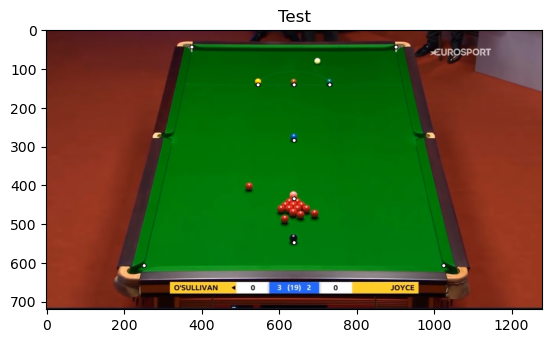

In [124]:
test_image = image_rgb.copy()
for i, point_no in enumerate(world_coords_3d):
    point_o = np.concatenate((point_no, np.array([1])))
    point = np.matmul(M_camera,np.transpose(point_o))
    point = point / point[2]
    print(point)
    cv2.circle(test_image, (int(point[0]), int(point[1])), 6, (0, 0, 0), -1)
    cv2.circle(test_image, (int(point[0]), int(point[1])), 4, (255, 255, 255), -1)
plt.imshow(test_image)
plt.title('Test')
plt.show()

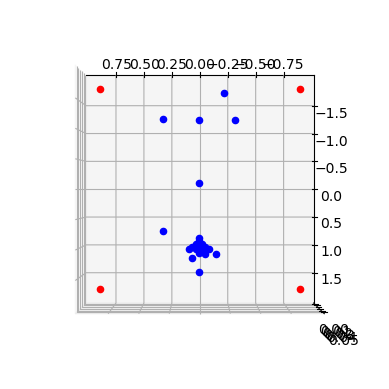

In [135]:
Z_COORD = BALL_RADIUS*2

split = np.split(M_camera, 2, axis=1)
MAT = split[0]
arr = split[1]
arr[:,0] = Z_COORD*arr[:,0]
arr = np.sum(arr, axis=1)
MAT = np.concatenate((MAT, np.array([[-1],[-1],[-1]])), axis=1)
centroids_3D = np.zeros((len(centroids),3))
for i, ball in enumerate(centroids):
    ball = np.concatenate((ball, np.array([1])))
    MAT[:,2] = ball*MAT[:,2]
    coord = np.linalg.solve(MAT, arr)
    coord[2] = Z_COORD
    centroids_3D[i] = coord
    MAT[:,2] = np.array([-1,-1,-1])

    
A_2 = (0,3.569,0)
B_2 = (0,0,0)
C_2 = (1.778,0,0)
D_2 = (1.778, 3.569,0)
angles = np.float32([A_2,B_2,C_2,D_2])
angles[:, 0] -= 1.778/2
angles[:, 1] -= 3.569/2
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, point in enumerate(centroids_3D):
    ax.scatter(point[0], point[1], point[2], c='b', marker='o')
for i, point in enumerate(angles):
    ax.scatter(point[0], point[1], point[2], c='r', marker='o')
ax.view_init(elev=90,azim=90)
plt.show()